1000.0 1000
Total number of shots:1
1000 0.0025


/scratch/stan/stride/stride/problem/acquisitions.py:1071: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  slider = Slider(ax_shot, 'shot ID',


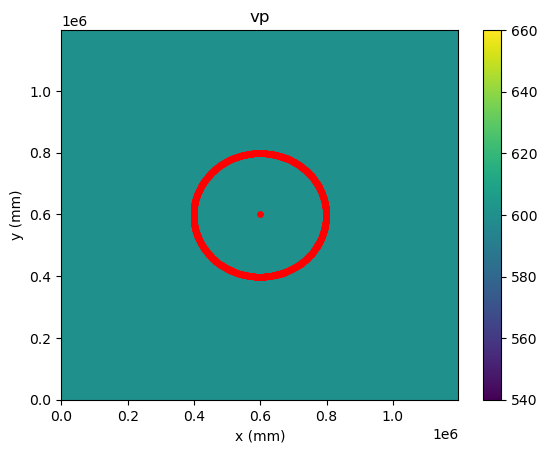

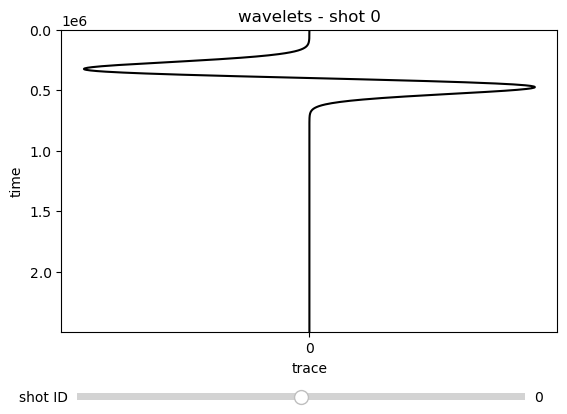

In [2]:
from stride import *
import mosaic
import json
from stride.utils import wavelets
import os

config_file = "./configs/0805_pinn.json"

with open(config_file, "r") as file:
        config = json.load(file)
foldername = os.path.basename(config_file).split('.')[0]
dx = config["dx"]
cfl = config["cfl"]
num_source = config["num_source"]
num_receiver = config["num_receiver"]
num_iters = config["num_iters"]
max_freqs = config["max_freqs"]  # [0.3e6, 0.4e6]
batchsize = config["batchsize"]
map_path = config["map_path"]
# f_centre = config["source_centerfreq"]
f_centre = 3

# dx_scale = dx / 0.3e-3
# cfl_scale 
# = cfl / 0.5
# basics setting
# grid_size = int(2100 / dx_scale)
dx  = 3.
sos = 600.0
time_span = 2.5
dt = cfl * dx / sos
Nt =int(time_span / dt) 
grid_size = 400
space = Space(
    # shape=(grid_size, grid_size), extra=(100, 100), absorbing=(80, 80), spacing=dx
    shape=(grid_size, grid_size), extra=(50, 50), absorbing=(40, 40), spacing=dx
)
time = Time(
    # start=0.0e-7, step=cfl * dx / sos, num=int(20000 / dx_scale / cfl_scale)
    # start=0., step=cfl * dx / sos, num=int(10000 / dx_scale / cfl_scale)
    start=0., step=dt , num=Nt
)
grid = Grid(space, time)
problem = Problem(
    name="fullbodyring", space=space, time=time
)

# define transducer geometry
problem.transducers.default()
geometry_type = "elliptical"
problem.geometry.default(geometry_type, num_receiver, radius=[200, 200])
# problem.geometry.default(geometry_type, num_receiver)
receivers = problem.geometry.locations

def ellipt_coordinates(num, radius):  # centered at [0,0]

    angles = np.linspace(0, 2 * np.pi, num, endpoint=False)
    geometry = np.zeros((num, 2))
    for index, angle in zip(range(num), angles):

        geometry[index, 0] = radius[0] * np.cos(angle)
        geometry[index, 1] = radius[1] * np.sin(angle)

    return geometry

# offset = problem.geometry.num_locations
# coords_offest = grid_size / 2 * dx
# coordinates = ellipt_coordinates(num_source, [0.22, 0.22])
# for index in range(coordinates.shape[0]):
#     _coordinates = coordinates[index, :]
#     if len(_coordinates) != problem.geometry.space.dim:
#         _coordinates = np.pad(_coordinates, ((0, 1),))
#         _coordinates[-1] = problem.geometry.space.limit[2] / 2

#     problem.geometry.add(
#         index + offset,
#         problem.geometry._transducers.get(0),
#         _coordinates + coords_offest,
#     )
center = grid_size * dx /2
problem.geometry.locations[0].coordinates = np.array([center,center])
sources = [problem.geometry.locations[0]]

# ------------------------ Forward problme ------------------------ #
t = np.arange(0, time.num * time.step, time.step)
b = 0.1 / f_centre
# b = 2 / f_centre
# delay = (0.5/1.3) * time.num * time.step
delay = 0.4
# delay = 0.03 * time.num * time.step
# wave = np.exp(-((t - delay) ** 2) / b**2) * np.cos(
#     2 * np.pi * f_centre * (t - delay)
# )
wave = (2*(np.pi * f_centre*(t-delay)))*np.exp(-(np.pi * f_centre*(t-delay))**2)


for source in sources:
    problem.acquisitions.add(
        Shot(
            source.id,
            sources=[source],
            receivers=receivers,
            geometry=problem.geometry,
            problem=problem,
        )
    )

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wave

print(f"Total number of shots:{len(problem.acquisitions.shots)}")

# define sos ground true map  /
# map = np.load(map_path)
# pad_height = (grid_size - map.shape[0]) // 2
# pad_width = (grid_size - map.shape[1]) // 2

# data = np.pad(
#     map,
#     pad_width=((pad_height, pad_height), (pad_width, pad_width)),
#     constant_values=1500,
# )
# data = np.rot90(data, k =-1)
# data = np.full((grid_size,grid_size), 600)

data = np.full((grid_size, grid_size), 600, dtype=int)
# s = 0.08 / dx
# R = s / np.sqrt(3)
# angles = np.deg2rad([90, 210, 330])  # Convert degrees to radians
# centers = [(R * np.cos(theta), R * np.sin(theta)) for theta in angles]
# radii = [0.02 / dx, 0.03 / dx, 0.04 / dx]
# sos_vals = [1450, 1475, 1550]
# sos_vals = 700
# y, x = np.ogrid[:grid_size, :grid_size]
# origin = grid_size / 2
# radius = 50
# center = [300,300]
# # for center, radius, sos in zip(centers, radii, sos_vals):
# mask = (x - center[0] - origin) ** 2 + (
#     y - center[1] - origin
# ) ** 2 <= radius**2
# data[mask] = sos
# radius = 80  # You can adjust this value as needed
# center_x = grid_size - radius - 10
# center_y = grid_size - radius - 10

# # Create the circle
# for i in range(grid_size):
#     for j in range(grid_size):
#         if (i - center_x)**2 + (j - center_y)**2 <= radius**2:
#             data[i, j] = 700
            
vp_true = ScalarField(name="vp", grid=problem.grid, data=data)
problem.medium.add(vp_true)
problem.plot()
print(time.num, time.step)

In [22]:
# map = np.load(map_path)
# pad_height = (grid_size - map.shape[0]) // 2
# pad_width = (grid_size - map.shape[1]) // 2

# data = np.pad(
#     map,
#     pad_width=((pad_height, pad_height), (pad_width, pad_width)),
#     constant_values=1500,
# )
# # data = np.rot90(data, k =-1)
# plt.figure(figsize=(10, 8))
# plt.imshow(data, aspect="auto", interpolation="none")
# plt.colorbar()  # Adds a color bar to indicate the scale
# plt.title("Speed of sound map")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.show()

In [5]:
pde = IsoAcousticDevito(space=space, time=time,kernel="OT4")
sub_problem = problem.sub_problem(shot.id)
shot_wavelets = sub_problem.shot.wavelets

# Run
traces_0 = await pde(shot.wavelets, vp_true, problem=sub_problem, 
                     diff_source=True,
                     boundary_type='complex_frequency_shift_PML_2',
                     save_wavefield=True,
                     platform="nvidia-acc",
                     devito_args={"deviceid": 0},
                     save_undersampling = 1,
                     )

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(ShotID 0) Preparing to run state for shot
(ShotID 0) Selected boundary type complex_frequency_shift_PML_2
(ShotID 0) Estimated bandwidth for the propagated wavelet 0.000-0.000 MHz
(ShotID 0) Spatial grid spacing (3000.000 mm | 45.455 PPW) is below dispersion limit (27272.727 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (2500.000 μs | 50%) is above OT2 limit (2250.791 μs) and below OT4 limit (4051.423 μs)
(ShotID 0) Selected undersampling level 1
(ShotID 0) Selected time stepping scheme OT4
(ShotID 0) Higdon and PML boundary conditions are unstable beyond OT2 limits
(ShotID 0) Expected wavefield size 0.9323 GB
Operator `acoustic_iso_state` instance configuration:
	 * name=acoustic_iso_state
	 * subs={h_x: 3.0, h_y: 3.0, dt: 0.0025}
	 * opt=advanced-fsg
	 * autotuning=off
	 * compiler=nvc
	 * language=openacc
	 * platform=nvidiaX
	 * devicec

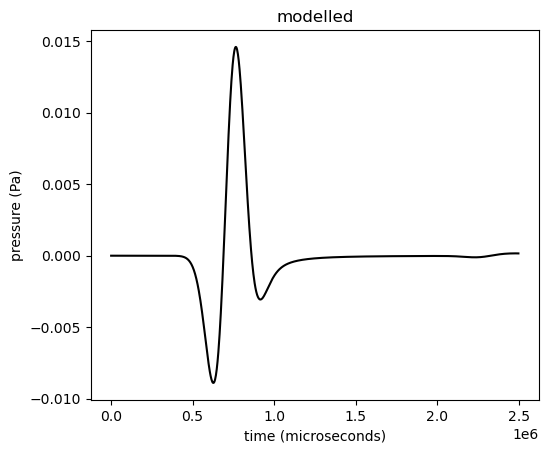

In [6]:
import matplotlib.pyplot as plt

traces_0.plot_one(150, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('pressure (Pa)')
plt.subplots_adjust(left=0.2)
plt.show()

In [31]:
arr_max = np.max(abs(pde.wavefield.data))
print(arr_max)
print(pde.wavefield.data.shape)

60.59809
(1001, 500, 500)


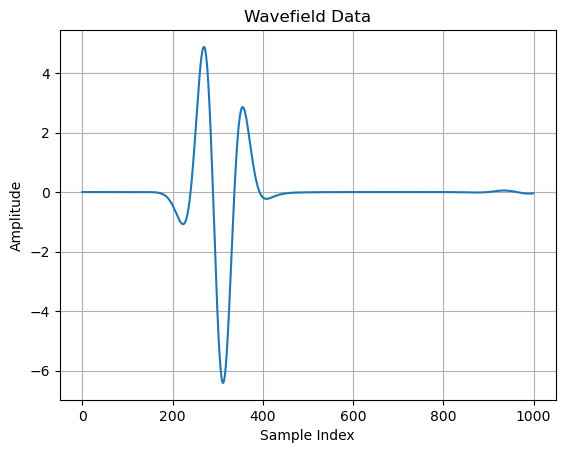

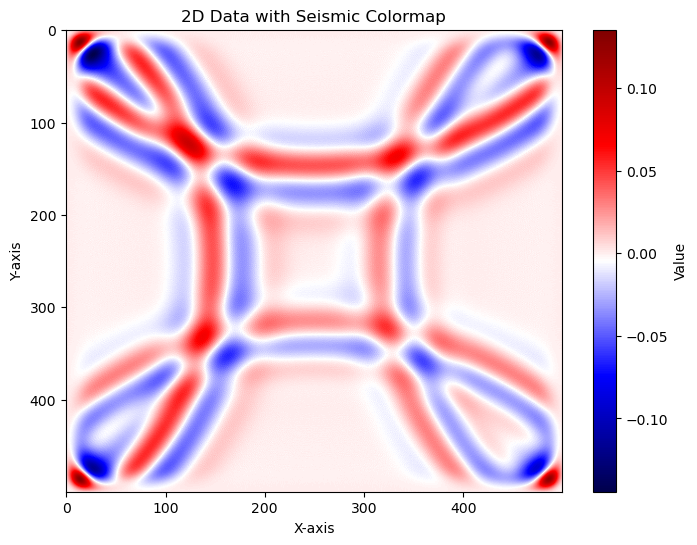

In [7]:
wav_data = pde.wavefield.data[:-1]
plt.figure()
plt.plot(wav_data[:,300,300])
plt.title('Wavefield Data')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
# print(wav_data_norm[:-1,::3,::3].shape)

plt.figure(figsize=(8, 6))
# plt.imshow(wav_data[160], cmap='seismic', aspect='auto', vmin = -1 , vmax =1)
plt.imshow(wav_data[-100], cmap='seismic', aspect='auto')
plt.colorbar(label='Value')
plt.title('2D Data with Seismic Colormap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()



In [35]:
savename = os.path.join("/home/stan/data/pinn/data" , "0814_f3_homo")
np.savez_compressed(savename, data = wav_data)

(500, 500)


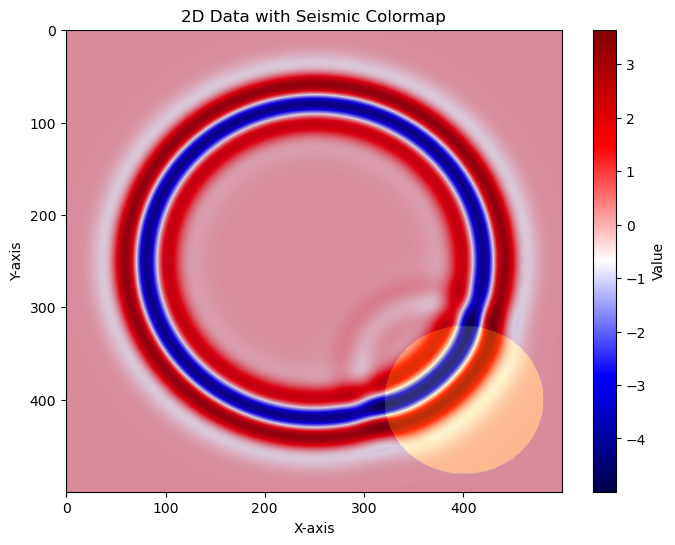

In [23]:
smap = data.copy()
pad_height = (500 - smap.shape[0]) // 2
pad_width = (500 - smap.shape[1]) // 2

smap = np.pad(
    smap,
    pad_width=((pad_height, pad_height), (pad_width, pad_width)),
    constant_values=600,
)
print(smap.shape)


plt.figure(figsize=(8, 6))
# plt.imshow(wav_data[160], cmap='seismic', aspect='auto', vmin = -1 , vmax =1)
plt.imshow(wav_data[510], cmap='seismic', aspect='auto')
plt.colorbar(label='Value')
plt.imshow(smap, aspect='auto', alpha= 0.2)
plt.title('Wave propogation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [ ]:
savename = os.path.join("/home/stan/data/pinn/data" , "0814_f3_1disk_map")
np.savez_compressed(savename, data = smap)
